<a href="https://colab.research.google.com/github/nabilafirdaiss/CBR_MA_KORUPSI/blob/main/CBR_KORUPSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <a id='representation'></a> 1. Case Representation

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
import pandas as pd, re

# Load CSV hasil scraping
CSV_PATH = '/content/drive/MyDrive/PK/CSV/putusan_ma__2025-06-27.csv'
df = pd.read_csv(CSV_PATH)

# Labeling: 0 = Pertama, 1 = Banding
label_map = {'Pertama':0, 'Banding':1}
df = df[df['tingkat_proses'].isin(label_map.keys())].copy()
df['label'] = df['tingkat_proses'].map(label_map)

# Gabungkan teks
text_cols = ['amar', 'kaidah', 'abstrak', 'text_pdf']
df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)

print("Jumlah data:", len(df))
print(df['label'].value_counts())


Jumlah data: 46
label
0    33
1    13
Name: count, dtype: int64


## <a id='retrieval'></a> 2. Case Retrieval

TFIDF

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Contoh: df harus punya kolom teks dan label
# Misal kolom teks = 'combined_text', label = 'label'

texts = df['combined_text'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

vectorizer = TfidfVectorizer(max_features=5000)  # Batasi fitur untuk efisiensi
X_tfidf = vectorizer.fit_transform(texts)

# Keep track of original indices
original_indices = df.index.tolist()

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_tfidf, labels, original_indices, test_size=0.3, random_state=42, stratify=labels)

SVM

In [59]:
svm_clf = LinearSVC(class_weight='balanced', C=1.0)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

NB

In [64]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)


## <a id='reuse'></a> 3. Case / Solution Reuse

In [60]:
# ------------------------------------------------------------------
# 1. Siapkan retriever (cosine) setelah TF-IDF selesai
# ------------------------------------------------------------------
from sklearn.neighbors import NearestNeighbors

retriever = NearestNeighbors(n_neighbors=5, metric="cosine")
retriever.fit(X_tfidf)                # X_tfidf = vectorizer.fit_transform(texts)

# ------------------------------------------------------------------
# 2. Fungsi ambil top-k kasus mirip
# ------------------------------------------------------------------
def retrieve_cases(query: str, k: int = 5) -> pd.DataFrame:
    """Kembalikan k kasus paling mirip berdasarkan cosine-similarity TF-IDF."""
    q_vec = vectorizer.transform([query])
    _, idx = retriever.kneighbors(q_vec, n_neighbors=k)
    return df.iloc[idx[0]].reset_index(drop=True)

# ------------------------------------------------------------------
# 3. Fungsi prediksi dengan (a) SVM  (b) CBR-reuse mayoritas
# ------------------------------------------------------------------
def predict_outcome_with_reuse(query: str, k: int = 5):
    # --- CBR: ambil top-k kasus mirip ---
    top_k_cases = retrieve_cases(query, k)

    # Mayoritas label → solusi reuse
    reused_label  = top_k_cases["label"].mode().iloc[0]
    reused_solusi = "BANDING" if reused_label == 1 else "PERTAMA"

    # --- Klasifikasi langsung dengan SVM ---
    q_vec      = vectorizer.transform([query])
    pred_label = svm_clf.predict(q_vec)[0]
    svm_solusi = "BANDING" if pred_label == 1 else "PERTAMA"

    # --- Tampilkan hasil ---
    print(f">>> Prediksi SVM        : {svm_solusi}")
    print(f">>> Prediksi CBR (reuse): {reused_solusi}")
    print("\nTop-k kasus mirip:")
    display(top_k_cases[["nomor", "judul", "tingkat_proses"]])

    return {"svm": svm_solusi,
            "cbr": reused_solusi,
            "top_cases": top_k_cases}


Demo

In [61]:
query_demo = """
Terdakwa menyalahgunakan dana proyek pembangunan dan mengajukan banding
atas putusan pengadilan negeri.
"""

predict_outcome_with_reuse(query_demo, k=5)

>>> Prediksi SVM        : PERTAMA
>>> Prediksi CBR (reuse): BANDING

Top-k kasus mirip:


,nomor,judul,tingkat_proses
0,Putusan PN AMBON Nomor 11/Pid.Sus-TPK/2025/PN ...,Putusan PN AMBON Nomor 11/Pid.Sus-TPK/2025/PN ...,Pertama
1,Putusan PT SURABAYA Nomor 64/PID.SUS-TPK/2024/...,Putusan PT SURABAYA Nomor 64/PID.SUS-TPK/2024/...,Banding
2,Putusan PT BANGKA BELITUNG Nomor 9/PID.TPK/202...,Putusan PT BANGKA BELITUNG Nomor 9/PID.TPK/202...,Banding
3,Putusan PN SURABAYA Nomor 117/Pid.Sus-TPK/2024...,Putusan PN SURABAYA Nomor 117/Pid.Sus-TPK/2024...,Pertama
4,Putusan PT MEDAN Nomor 20/PID.SUS-TPK/2025/PT ...,Putusan PT MEDAN Nomor 20/PID.SUS-TPK/2025/PT ...,Banding


{'svm': 'PERTAMA',
 'cbr': 'BANDING',
 'top_cases':                                                judul  \
 0  Putusan PN AMBON Nomor 11/Pid.Sus-TPK/2025/PN ...   
 1  Putusan PT SURABAYA Nomor 64/PID.SUS-TPK/2024/...   
 2  Putusan PT BANGKA BELITUNG Nomor 9/PID.TPK/202...   
 3  Putusan PN SURABAYA Nomor 117/Pid.Sus-TPK/2024...   
 4  Putusan PT MEDAN Nomor 20/PID.SUS-TPK/2025/PT ...   
 
                                                nomor tingkat_proses  \
 0  Putusan PN AMBON Nomor 11/Pid.Sus-TPK/2025/PN ...        Pertama   
 1  Putusan PT SURABAYA Nomor 64/PID.SUS-TPK/2024/...        Banding   
 2  Putusan PT BANGKA BELITUNG Nomor 9/PID.TPK/202...        Banding   
 3  Putusan PN SURABAYA Nomor 117/Pid.Sus-TPK/2024...        Pertama   
 4  Putusan PT MEDAN Nomor 20/PID.SUS-TPK/2025/PT ...        Banding   
 
                                klasifikasi             kata_kunci  tahun  \
 0  Pidana Khusus \n Pidana Khusus  Korupsi  Tindak Pidana Korupsi   2025   
 1  Pidana Khusus

## <a id='evaluation'></a> 5. Evaluasi Model

In [62]:
print("🔹 SVM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


🔹 SVM Performance:
Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.75      0.86         4

    accuracy                           0.93        14
   macro avg       0.95      0.88      0.90        14
weighted avg       0.94      0.93      0.93        14



In [65]:
print("🔹 Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=["Pertama", "Banding"]))

🔹 Naive Bayes Performance:
Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

     Pertama       0.71      1.00      0.83        10
     Banding       0.00      0.00      0.00         4

    accuracy                           0.71        14
   macro avg       0.36      0.50      0.42        14
weighted avg       0.51      0.71      0.60        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


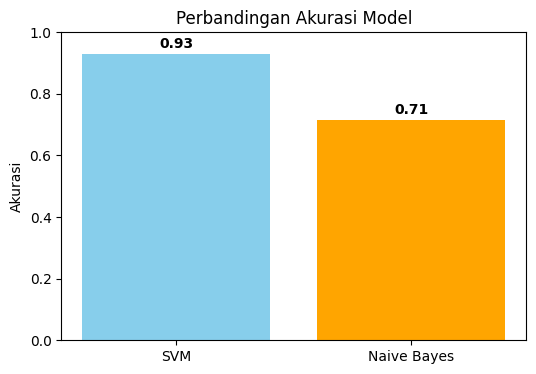

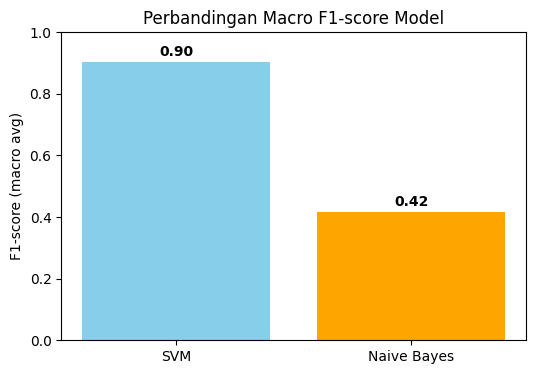

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Hitung metrik evaluasi
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_nb = accuracy_score(y_test, y_pred_nb)

f1_svm = f1_score(y_test, y_pred_svm, average="macro")
f1_nb = f1_score(y_test, y_pred_nb, average="macro")

# Data untuk visualisasi
models = ['SVM', 'Naive Bayes']
accuracies = [acc_svm, acc_nb]
f1_scores = [f1_svm, f1_nb]

# 🎯 Visualisasi Akurasi
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# 🎯 Visualisasi F1-score
plt.figure(figsize=(6, 4))
plt.bar(models, f1_scores, color=['skyblue', 'orange'])
plt.title('Perbandingan Macro F1-score Model')
plt.ylabel('F1-score (macro avg)')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


In [63]:
import numpy as np

# Cari indeks prediksi salah di subset test_indices
wrong_idx_in_test_indices = np.where(np.array(y_test) != np.array(y_pred_svm))[0]

print(f"\n🛑 Jumlah prediksi salah: {len(wrong_idx_in_test_indices)} dari {len(y_test)} data uji")
print("Contoh kasus salah klasifikasi:")

for i in wrong_idx_in_test_indices[:5]:
    # Get the original index from the stored test_indices
    original_df_index = test_indices[i]
    row = df.loc[original_df_index]

    print(f"\n🔸 Nomor Putusan: {row['nomor']}")
    print(f"Judul           : {row['judul']}")
    print(f"Asli            : {'Banding' if y_test[i]==1 else 'Pertama'}")
    print(f"Prediksi SVM    : {'Banding' if y_pred_svm[i]==1 else 'Pertama'}")

    combined = row.get('combined_text', '')
    if isinstance(combined, str):
        snippet = combined[:250].replace('\n', ' ')
    else:
        snippet = '[Teks tidak tersedia]'

    print(f"Cuplikan Putusan: {snippet}")


🛑 Jumlah prediksi salah: 1 dari 14 data uji
Contoh kasus salah klasifikasi:

🔸 Nomor Putusan: Putusan PT MALUKU UTARA Nomor 15/PID.SUS-TPK/2024/PT TTE Tanggal 31 Desember 2024 —Pembanding/Terbanding/Penuntut Umum VII : R. GILANG WARIH PRAKOSO, S.H.Terbanding/Pembanding/Terdakwa : NURAKSAR KODJA Diwakili Oleh : Mayor Chk Wirya, S.H.
Judul           : Putusan PT MALUKU UTARA Nomor 15/PID.SUS-TPK/2024/PT TTE Tanggal 31 Desember 2024 —Pembanding/Terbanding/Penuntut Umum VII : R. GILANG WARIH PRAKOSO, S.H.Terbanding/Pembanding/Terdakwa : NURAKSAR KODJA Diwakili Oleh : Mayor Chk Wirya, S.H.
Asli            : Banding
Prediksi SVM    : Pertama
Cuplikan Putusan: Lain-lain —  Direktori Putusan Mahkamah Agung Republik Indonesia putusan.mahkamahagung.go.id  Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Repub
